In [146]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def BuildData(folder, sound_engine_name, date):

    # Get the list of files in the 'editor_data' folder
    folder_path = os.path.join(os.getcwd(), folder)
    file_list = os.listdir(folder_path)

    # Filter the files that contain 'CsoundUnity' in their names
    filtered_files = [file for file in file_list if sound_engine_name in file and date in file]

    # Initialize an empty DataFrame to store the merged data
    merged_df = pd.DataFrame()

    # Iterate over the filtered files and merge them into the DataFrame
    for file in filtered_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        merged_df = pd.concat([merged_df, df])

    # Group the data by 'sources' column and assign contiguous group numbers
    grouped_df = merged_df.groupby(merged_df['sources'].ne(merged_df['sources'].shift()).cumsum())  

    def dataStats(field):
        # Initialize an empty DataFrame to store the results
        result_df = pd.DataFrame()
        # Iterate over the groups and calculate descriptive statistics
        for name, group in grouped_df:
            
            # Calculate descriptive statistics for the 'audio_frame_t_ms' column
            stats = group[field].describe()
            
            # Calculate the median
            median = group[field].median()
            
            # Create a new DataFrame with the source, audio_frame_t_ms, and descriptive statistics
            temp_df = pd.DataFrame({'sources': group['sources'].iloc[0],
                                    'count': stats['count'],
                                    'mean': stats['mean'],
                                    'std': stats['std'],
                                    'min': stats['min'],
                                    '25%': stats['25%'],
                                    '50%': stats['50%'],
                                    '75%': stats['75%'],
                                    'max': stats['max'],
                                    'median': median}, index=[0])
            
            # Append the temporary DataFrame to the result DataFrame
            result_df = pd.concat([result_df, temp_df], ignore_index=True)

        # return the result DataFrame
        return result_df
    
    return merged_df, dataStats('audio_frame_t_ms'), dataStats('audio_memory_mb')

def Plot(dataPerSources, sound_engine_name, title, yLabel, xlabel = 'Number of Audio Sources', marker = 'o-', color='blue', ecolor='orange', drawBufferLimit = False):

    # Set the x-axis values as the index of the dataframe
    x = dataPerSources.index

    # Set the y-axis values as the mean values from the 'mean' column
    y = dataPerSources['mean']

    # Plot the data
    #plt.plot(x, y, color='blue', marker='o', linestyle='-', label='Mean')

    # Set the x-axis values as the index of the dataframe
    x = dataPerSources.index

    # Set the y-axis values as the mean values from the 'mean' column
    y = dataPerSources['mean']

    # Set the y-axis error values as the standard deviation values from the 'std' column
    y_error = dataPerSources['std']

    # Plot the mean with error bars
    plt.errorbar(x, y, yerr=y_error, fmt=marker, label='Mean', color=color, ecolor=ecolor, elinewidth=1, capsize=3, markersize=4)

    if drawBufferLimit:
        # Set the y-coordinate of the horizontal line
        y_line = 21.33

        # Set the color of the horizontal line (configurable)
        line_color = 'green'

        # Add the horizontal line to the plot
        plt.axhline(y=y_line, color=line_color, label='_nolegend_')

        # Add the value to the left of the line
        plt.text(6, y_line - 0.8, 'Buffer Latency = ' + str(y_line) + ' ms', color=line_color, ha='right', va='center', fontsize=8)    
    

    # Set Title
    plt.title(title)

    # Set the x-axis label
    plt.xlabel(xlabel)
    # Set the y-axis label
    plt.ylabel(yLabel)

    # Set the x-axis ticks as the values in dataPerSources['sources']
    plt.xticks(x, dataPerSources['sources'])

    # Show the plot
    #plt.show() # Uncomment this line to show individual plots


def Plot_CPU(folder, sound_engine_name, device, date, xlabel = 'Number of Audio Sources', marker = 'o-', color_frame_time='blue', ecolor_frame_time='orange', drawBufferLimit=True):
    all_data, frame_time_data, _ = BuildData(folder, sound_engine_name, date)
    Plot(frame_time_data, sound_engine_name, device + ' DSP Time (ms)', 'DSP Time (ms)', xlabel = xlabel,  marker=marker, color=color_frame_time, ecolor=ecolor_frame_time, drawBufferLimit=drawBufferLimit)
    return all_data, frame_time_data

def Plot_Memory(folder, sound_engine_name, device, date, xlabel = 'Number of Audio Sources', marker = 'o-', color_memory='blue', ecolor_memory='orange'):
    all_data, _, memory_data = BuildData(folder, sound_engine_name, date)
    Plot(memory_data, sound_engine_name, device + ' Memory (MB)', 'Audio Memory (MB)', xlabel = xlabel, marker=marker, color=color_memory, ecolor=ecolor_memory)
    return all_data, memory_data

def Plot_CPU_Memory(folder, sound_engine_name, date, color_frame_time='blue', color_memory='green', ecolor_frame_time='orange', ecolor_memory='cyan'):
    _, frame_time_data, memory_data = BuildData(folder, sound_engine_name, date)
    Plot(frame_time_data, sound_engine_name, 'Audio Frame Time (ms)', 'DSP Time (ms)', color=color_frame_time, ecolor=ecolor_frame_time)
    Plot(memory_data, sound_engine_name, 'Audio Memory (MB)', 'Audio Memory (MB)', color=color_memory, ecolor=ecolor_memory)

def Plot_Comparison(folder, csound_date, chuck_date, title,  file_name, isDSP, drawBufferLimit = True, xseparation=2, legend_loc='upper left'):
    plt.figure(figsize=(10, 5))

    sound_engine = 'CsoundUnity'
    date = csound_date
    if isDSP:
        all_data_cs, data_cs = Plot_CPU(folder, sound_engine, title, date, drawBufferLimit=drawBufferLimit)
    else:
        all_data_cs, data_cs = Plot_Memory(folder, sound_engine, title, date)

    sound_engine = 'ChuckMainInstance'
    date = chuck_date
    if isDSP:
        all_data_chuck, data_chuck = Plot_CPU(folder, sound_engine, title, date, marker='s-', color_frame_time='red', ecolor_frame_time='grey', drawBufferLimit=drawBufferLimit)
    else:
        all_data_chuck, data_chuck = Plot_Memory(folder, sound_engine, title, date, marker='s-', color_memory='red', ecolor_memory='grey')

    # Set the legend labels
    plt.legend(['CsoundUnity', 'Chunity'], loc=legend_loc)

    plt.xticks(ticks=range(len(data_cs.index))[::xseparation], labels=data_cs['sources'][::xseparation])

    filepath = 'figures/'
    plt.savefig(filepath + file_name, bbox_inches='tight')

    plt.show()

    return all_data_cs, all_data_chuck



# Unity Editor
## Editor: Sine: DSP Time

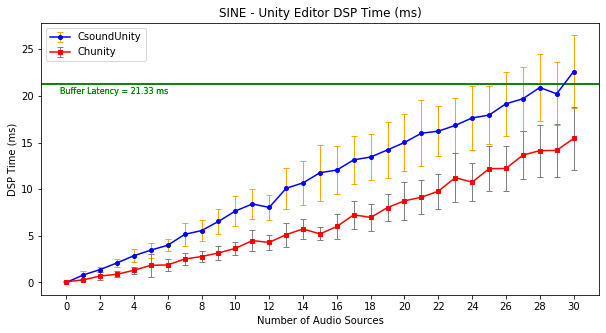

In [147]:
_ = Plot_Comparison('editor_data/sine_patch', '2024-03-04_11-15-51', '2024-03-04_11-19-53', 'SINE - Unity Editor', 'editor_sine_dsptime.pdf', True)

## Editor: Sine: Memory

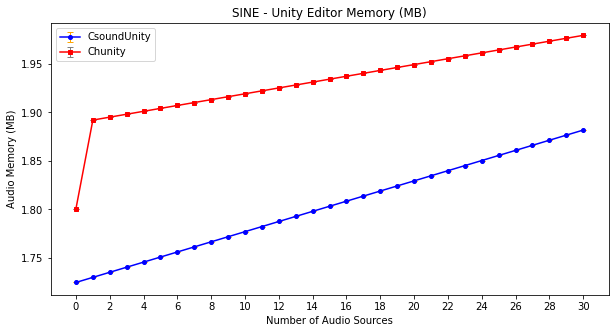

In [134]:
_ = Plot_Comparison('editor_data/sine_patch', '2024-03-04_11-15-51', '2024-03-04_11-19-53', 'SINE - Unity Editor', 'editor_sine_memory.pdf', False)

## Editor: Synthe: DSP Time

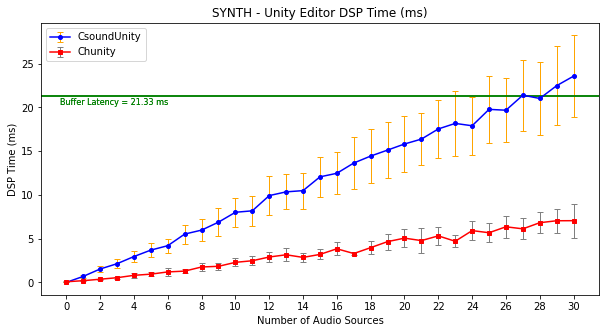

In [135]:
_ = Plot_Comparison('editor_data/simple_synthe', '2024-03-05_09-41-18', '2024-03-05_09-53-43', 'SYNTH - Unity Editor', 'editor_synthe_dsptime.pdf', True)

## Editor: Synthe: Memory

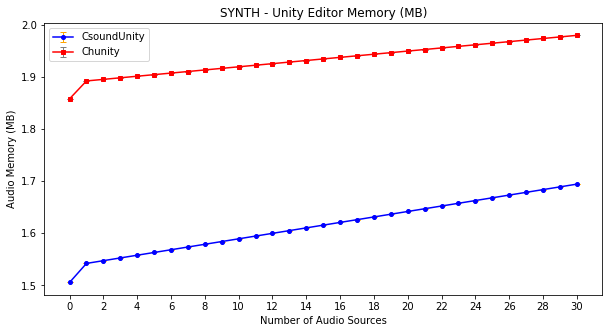

In [136]:
_ = Plot_Comparison('editor_data/simple_synthe', '2024-03-05_09-41-18', '2024-03-05_09-53-43', 'SYNTH - Unity Editor', 'editor_synthe_memory.pdf', False)

## Editor: Hanging Processes
### Editor: Resource Leak - CPU

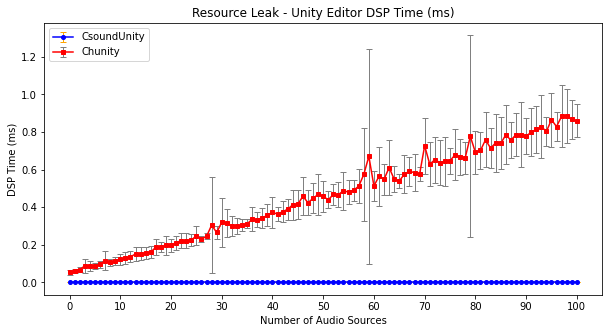

In [137]:
_ = Plot_Comparison('editor_data/hang', '2024-03-04_16-18-13', '2024-03-04_16-33-36', 'Resource Leak - Unity Editor', 'editor_hang_cpu.pdf', True, drawBufferLimit=False, xseparation=10)

### Editor: Memory Leak

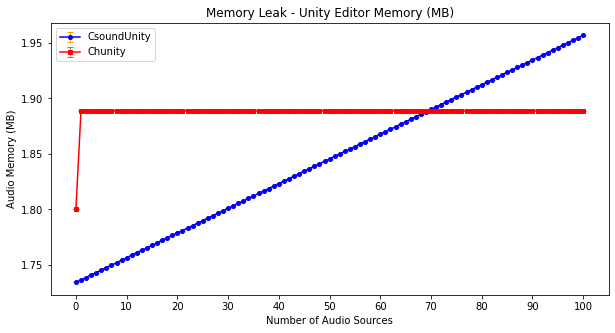

In [138]:
_ = Plot_Comparison('editor_data/hang', '2024-03-04_16-18-13', '2024-03-04_16-33-36', 'Memory Leak - Unity Editor', 'editor_hang_memory.pdf', False, drawBufferLimit=False, xseparation=10)

# Meta Quest 3
## Meta: Sine: DSP Time

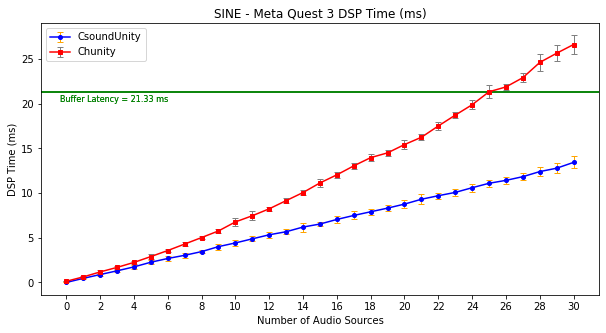

In [139]:
_ = Plot_Comparison('meta_quest_data/sine_patch', '2024-03-05_14-11-06', '2024-03-05_14-16-52', 'SINE - Meta Quest 3', 'meta_quest_sine_dsptime.pdf', True)

# Meta: Sine: Memory

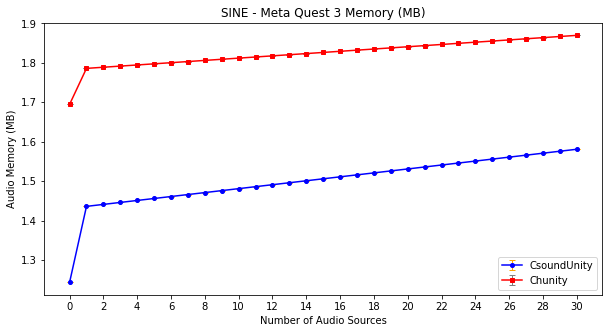

In [140]:
_ = Plot_Comparison('meta_quest_data/sine_patch', '2024-03-05_14-11-06', '2024-03-05_14-16-52', 'SINE - Meta Quest 3', 'meta_quest_sine_memory.pdf', False, legend_loc='lower right')

## Meta: Synthe: DSP Time

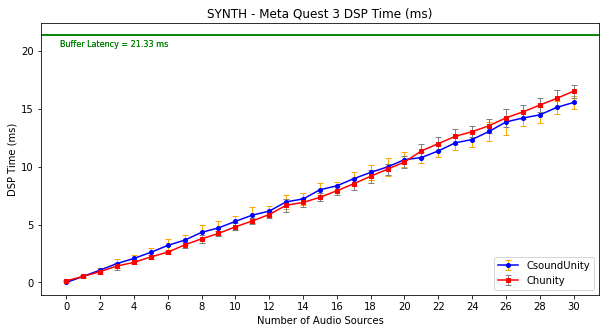

                            OLS Regression Results                            
Dep. Variable:       audio_frame_t_ms   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 6.211e+04
Date:                Wed, 06 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:40:32   Log-Likelihood:                -794.40
No. Observations:                 930   AIC:                             1593.
Df Residuals:                     928   BIC:                             1602.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0476      0.036      1.306      0.1

In [170]:
all_data_cs, all_data_chuck = Plot_Comparison('meta_quest_data/simple_synthe', '2024-03-05_12-55-56', '2024-03-05_12-46-23', 'SYNTH - Meta Quest 3', 'meta_quest_synthe_dsptime.pdf', True, legend_loc='lower right')

import statsmodels.api as sm

def CalculateLinearRegression(all_data):
    # Define the independent variable (X) and dependent variable (y)
    X = all_data['sources']
    y = all_data['audio_frame_t_ms']

    # Add a constant term to the independent variable
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # # Get the summary of the linear regression model
    summary = model.summary()

    # # Print the summary
    print(summary)

    return model

model_cs = CalculateLinearRegression(all_data_cs)
model_chuck =CalculateLinearRegression(all_data_chuck)

# Get the confidence intervals for the coefficients of both models
ci_cs = model_cs.conf_int(alpha=0.05)  # Default 95% CI
ci_chuck = model_chuck.conf_int(alpha=0.05)  # Default 95% CI

print('Confidence intervals for csound model:\n', ci_cs)
print('Confidence intervals for chuck model:\n', ci_chuck)

# Define the function to check overlap between confidence intervals
def check_CI_overlap(ci_1, ci_2, term_label):
    no_overlap = ci_1[1] < ci_2[0] or ci_2[1] < ci_1[0]
    if no_overlap:
        print(f'The confidence intervals for {term_label} do not overlap between the two models.')
    else:
        print(f'The confidence intervals for {term_label} overlap between the two models.')

# Check the overlap between the confidence intervals for the coefficients
# **** Non-overlapping confidence intervals are considered as statistically significantly differen
check_CI_overlap(ci_cs.loc['sources'], ci_chuck.loc['sources'], 'sources')
check_CI_overlap(ci_cs.loc['const'], ci_chuck.loc['const'], 'const')

## Meta: Synthe: Memory

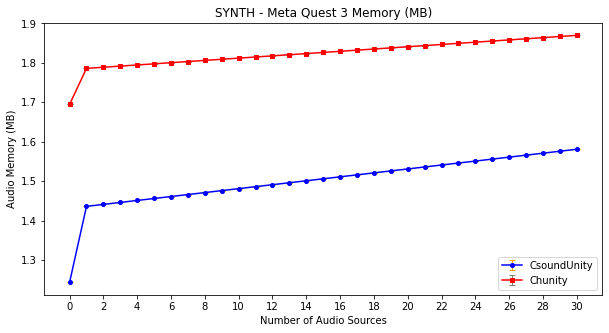

In [142]:
_ = Plot_Comparison('meta_quest_data/simple_synthe', '2024-03-05_12-55-56', '2024-03-05_12-46-23', 'SYNTH - Meta Quest 3', 'meta_quest_synthe_memory.pdf', False, legend_loc='lower right')

## Meta: Hanging Processes
### Meta: Resource Leak - CPU

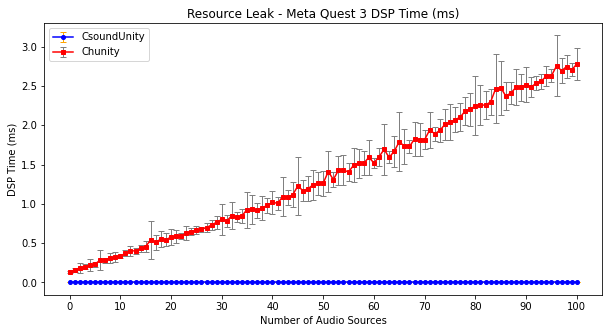

In [143]:
_ = Plot_Comparison('meta_quest_data/hang', '2024-03-05_15-01-44', '2024-03-05_14-23-29', 'Resource Leak - Meta Quest 3', 'meta_quest_hang_cpu.pdf', True, drawBufferLimit=False, xseparation=10)

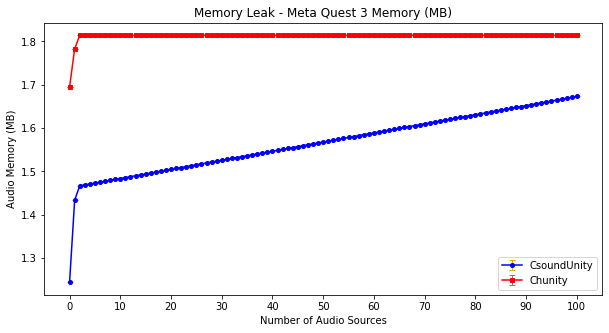

In [144]:
_ = Plot_Comparison('meta_quest_data/hang', '2024-03-05_15-01-44', '2024-03-05_14-23-29', 'Memory Leak - Meta Quest 3', 'meta_quest_hang_memory.pdf', False, drawBufferLimit=False, xseparation=10, legend_loc='lower right')